In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# Data

In [2]:
def getData(filename, verbose=0):
    df             = pd.read_csv(filename)
    df.columns     = df.columns.str.strip()
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%d/%m/%y %H')
    df.set_index('DATETIME', inplace=True)
    
    
    if verbose:
        print (' -------------------------------------------------------------------------------------- ')
        print (' - Total Len : ', len(df))
        print (' - Label     : ', df['ATT_FLAG'].value_counts())
        print (' - Columns   : ', df.columns, ' || Total : ', len(df.columns))
        print (' - Dates     : ', df.index[0], ' -- ', df.index[-1])
        # print (df.head())
    return df
    

if __name__ == "__main__":
    df_train = getData('data/BATADAL_dataset03.csv', verbose=1)
    df_val   = getData('data/BATADAL_dataset04.csv', verbose=1)

 -------------------------------------------------------------------------------------- 
 - Total Len :  8761
 - Label     :  0    8761
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')  || Total :  44
 - Dates     :  2014-01-06 00:00:00  --  2015-01-06 00:00:00
 -------------------------------------------------------------------------------------- 
 - Total Len :  4177
 - Label     :  -999    3958
 1       219
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
   

# PCA - Task
 - Plot the PCA residuals (train) in one signal
     - Do you see large abnormalities in the training data? Explain
 - What kind of anomalies can you detect using PCA?
     - volume anomaly
 - Note : It is best to remove such abnormalities from the training data since you only want to model normal behavior
 - Note : The residual is the difference between the original data and the data mapped onto the first k − 1 principal axes

# PCA - Step1 - Analysis

 - Num Components (preserving 99% variance) :  14


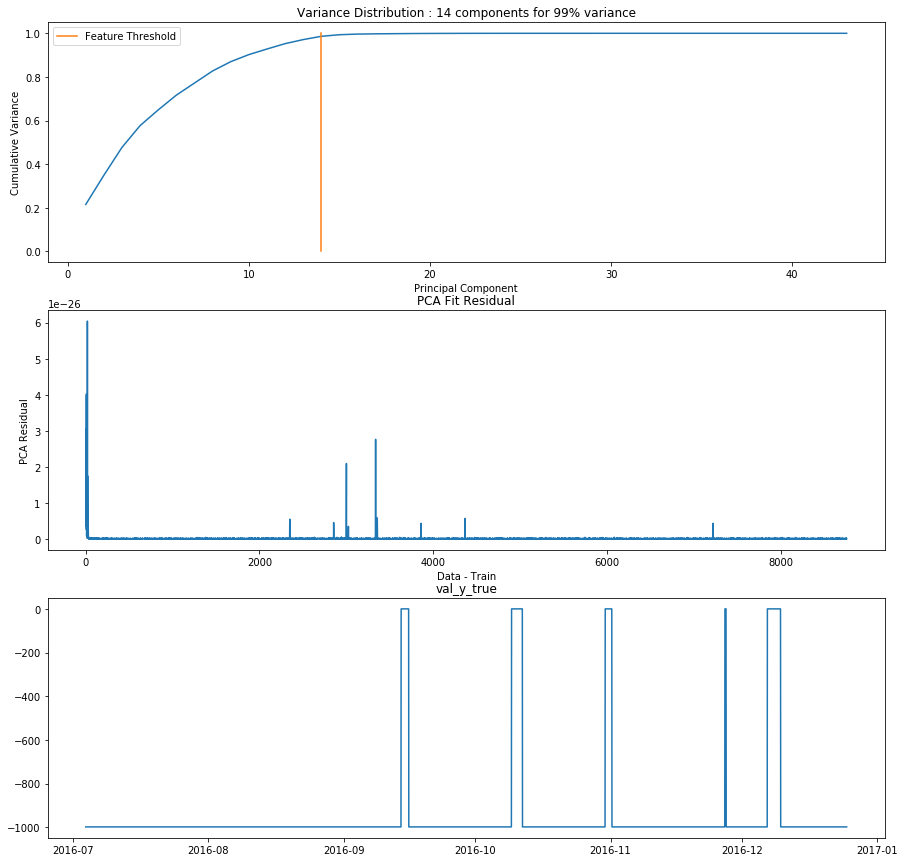

In [13]:
def applyPCA(df_train, df_val, n_components, plot=0):
    
    # Step0 - Some preprocessing
    df_train_X = df_train[df_train.columns[:-1]]
    df_train_X = df_train_X.astype('float64', copy=True)
    
    # Step1 - Normalizing
    train_X_norm = StandardScaler().fit_transform(df_train_X)
    
    # Step2 - PCA
    pca = PCA(n_components = n_components)
    train_X_norm_PCA = pca.fit_transform(train_X_norm)
    if n_components == 43:
        num_components = np.where(pca.explained_variance_ratio_.cumsum() > 0.99)[0][0]
        print (' - Num Components (preserving 99% variance) : ', num_components)
        # print (' - eigen values :  ', pcaObj.explained_variance_)
    else:
        num_components = n_components
    
    # Step3 - Inverse PCA
    train_X_norm_recon = pca.inverse_transform(train_X_norm_PCA)
    pca_diff           = train_X_norm - train_X_norm_recon
    pca_square         = np.square(pca_diff)
    pca_residual       = pca_square.sum(axis=1)
    
    if plot:
        f, axarr = plt.subplots(3,1, figsize = [15,15])
    
        #plt.bar(range(len(pca.explained_variance_)), pca.explained_variance_)
        #plt.show()
        
        y_axis = pca.explained_variance_ratio_.cumsum()
        x_axis = np.arange(1, train_X_norm_PCA.shape[1]+1)
        axarr[0].plot(x_axis, y_axis)
        axarr[0].set_xlabel('Principal Component')
        axarr[0].set_ylabel('Cumulative Variance')
        axarr[0].set_title('Variance Distribution : {0} components for 99% variance'.format(num_components))
        axarr[0].plot([num_components, num_components], [0, max(y_axis)], label='Feature Threshold')
        axarr[0].legend()
        
        axarr[1].set_xlabel('Data - Train')
        axarr[1].set_ylabel('PCA Residual')
        axarr[1].plot(pca_residual)
        axarr[1].set_title('PCA Fit Residual')
        
        axarr[2].plot(df_val['ATT_FLAG'])
        axarr[2].set_title('val_y_true')
        
        plt.show()
    
    # [Not for now] Step4 - Remove large residuals
    if (0):
        max_index = np.argmax(pca_residual)
        where = np.where(pca_residual > 1000)
        index = where[0]
        print('Before abnormality removal: ', train.shape)
        for i in index:
            row = train.iloc[[i]]
            train = train.drop(row.index)
        print('After abnormality removal: ', train.shape)
    
if __name__ == "__main__":
    applyPCA(df_train, df_val, n_components=43, plot=1)
    # applyPCA(df_train, df_val, n_components=14, plot=1)
    # applyPCA(df_val, df_val, n_components=14, plot=1)

# PCA - Step2 - Validation
 - [scikit-PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

 - 0. Some preprocessing ... 
 - 1. Normalizing the dataset ... 
  -- train_X_norm :  (8761, 43)
 - 2. Applying PCA ...
 - 3. Projecting train data on normal subspace ... 
 - 4 Normalizing validation data ... 
  -- val_X_norm :  (4177, 43)
 - 5. Projecting val data on anomalous subspace

 - 6. Results : 
  -- val_y_true :  Counter({-999: 3958, 1: 219})
  -- val_y_predict :  Counter({-999: 4052, 1: 125})
  -- conf mat :  [[3920   38]
 [ 132   87]]


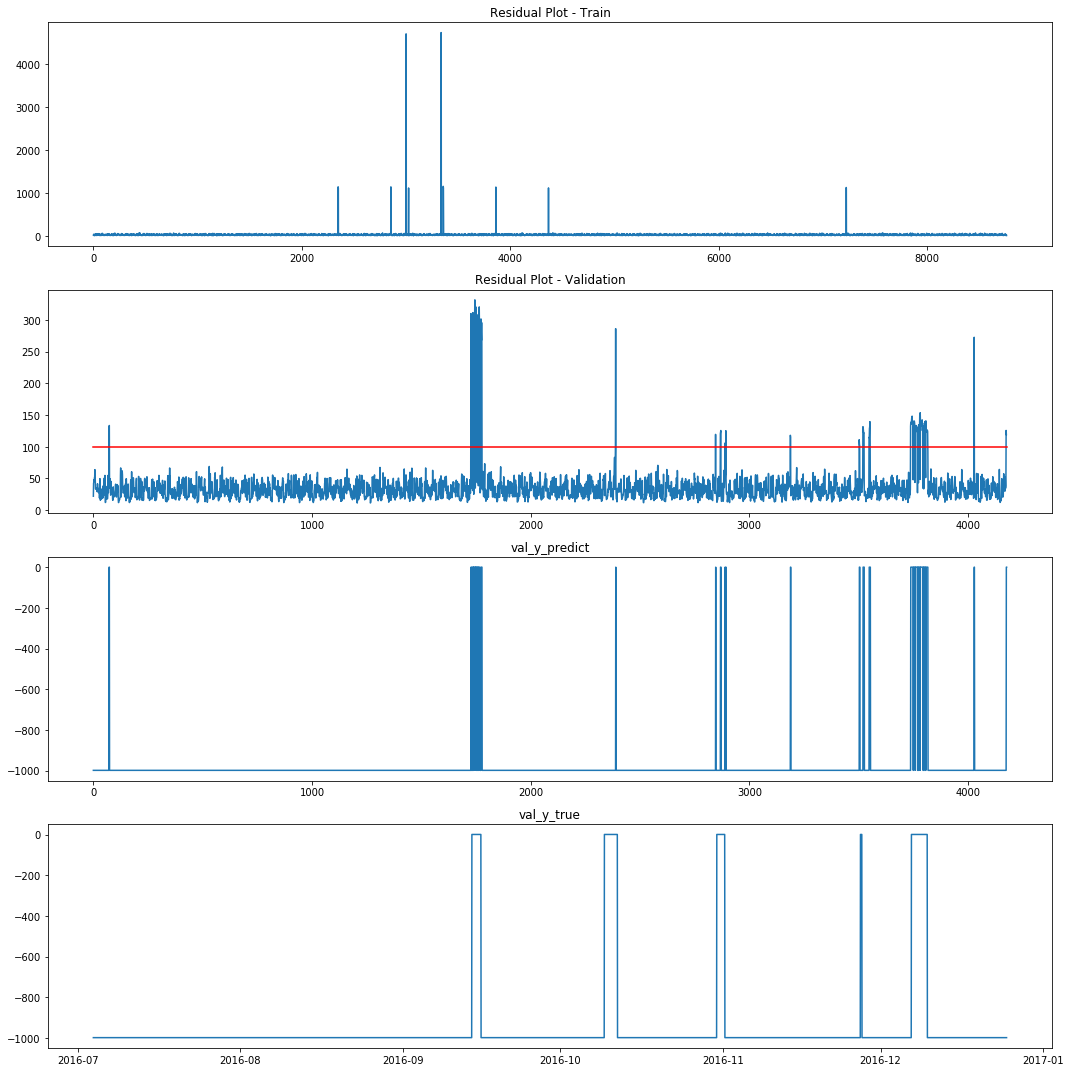

In [3]:
def projectToPCASubspace(df_train, df_val, n_components=14):
    
    if (1):
        # Step0 - Some preprocessing
        print (' - 0. Some preprocessing ... ')
        df_train_X = df_train[df_train.columns[:-1]]
        df_train_X = df_train_X.astype('float64', copy=True)

        # Step1 - Normalizing
        print (' - 1. Normalizing the dataset ... ')
        normalize = StandardScaler()
        train_X_norm = normalize.fit_transform(df_train_X)
        print ('  -- train_X_norm : ', train_X_norm.shape)

        # Step2 - PCA
        print (' - 2. Applying PCA ...')
        pca = PCA(n_components = n_components)
        train_X_norm_PCA = pca.fit_transform(train_X_norm)
        
        # Step3 - (Secton 5.1 of paper) - PCA residuals (on train)
        eigVect = pca.components_
        P       = np.transpose(eigVect)
        P_T     = np.transpose(P)
        C       = np.dot(P, P_T)
        I       = np.identity(train_X_norm.shape[1])
        
        # Step3.1 - Find project of train data on normal subspace - S
        print (' - 3. Projecting train data on normal subspace ... ')
        train_residual = np.zeros((train_X_norm.shape))
        for i in range(train_X_norm.shape[0]):
            y = np.transpose(train_X_norm[i])
            train_residual[i] = np.dot(I - C, y)
        pca_diff_train     = train_X_norm - train_residual
        pca_square_train   = np.square(pca_diff_train)
        pca_residual_train = pca_square_train.sum(axis=1)
        
        # Step3.2 - Remove errors and redo-PCA
        if (0):
            print ('  -- 3. Removing outliers in train data ... ')
            out_indices      = np.where(pca_residual_train > 500)
            train_X_norm_new = np.delete(train_X_norm, out_indices, axis=0)
            print ('   -- Old Data : ', len(train_X_norm), ' || New : ', len(train_X_norm_new))

            # Step4.2 - Retrain PCA
            print ('  -- 3. Retraining PCA on new train data ... ')
            pca = PCA(n_components = n_components)
            train_X_norm_PCA_new = pca.fit_transform(train_X_norm_new)
            eigVect = pca.components_
            P       = np.transpose(eigVect)
            P_T     = np.transpose(P)
            C       = np.dot(P, P_T)
    
    if (1):
        # Step0 - Some preprocessing
        df_val_X = df_val[df_val.columns[:-1]]
        df_val_X = df_val_X.astype('float64', copy=True)

        # Step1 - Normalizing
        print (' - 4 Normalizing validation data ... ')
        val_X_norm = normalize.fit_transform(df_val_X)
        print ('  -- val_X_norm : ', val_X_norm.shape) #[n_samples, n_dims]

        # Step2 -  (PCA residuals (on val))
        # Find project of val data on anomalous subspace - S_hat
        I            = np.identity(val_X_norm.shape[1])
        val_residual = np.zeros((val_X_norm.shape))
        
        # Find projection of val data on anomalous subspace
        print (' - 5. Projecting val data on anomalous subspace')
        for i in range(val_X_norm.shape[0]):
            y = np.transpose(val_X_norm[i])
            val_residual[i] = np.dot(I - C, y)
        
        pca_diff_val           = val_X_norm - val_residual
        pca_square_val         = np.square(pca_diff_val)
        pca_residual_val       = pca_square_val.sum(axis=1)
        
        threshold     = 100 
        val_y_true    = df_val['ATT_FLAG'].tolist()
        val_y_predict = np.copy(pca_residual_val)
        val_y_predict[val_y_predict < threshold]  = -999
        val_y_predict[val_y_predict >= threshold] = 1    
        val_y_predict = val_y_predict.astype(int)
        print ('')
        print (' - 6. Results : ')
        print ('  -- val_y_true : ', Counter(val_y_true))
        print ('  -- val_y_predict : ', Counter(val_y_predict))
        print ('  -- conf mat : ', confusion_matrix(val_y_true, val_y_predict))
        
        f,axarr = plt.subplots(4,1, figsize=(15,15))
        
        axarr[0].plot(pca_residual_train)
        axarr[0].set_title('Residual Plot - Train')
        
        axarr[1].plot(pca_residual_val)
        axarr[1].plot([0, len(pca_residual_val)], [threshold, threshold], 'r')
        axarr[1].set_title('Residual Plot - Validation')
        
        axarr[2].plot(val_y_predict)
        axarr[2].set_title('val_y_predict')
        
        axarr[3].plot(df_val['ATT_FLAG'])
        axarr[3].set_title('val_y_true')
        f.tight_layout()
        
        plt.show()
        
        return pca, val_y_predict

if __name__ == "__main__":
    pcaObj, val_y_predict  = projectToPCASubspace(df_train, df_val, n_components=14)
    Y_predicts = np.array(val_y_predict).reshape(-1,1)
    
    df_predict = pd.DataFrame(Y_predicts, columns=['PCA'])
    df_predict.to_csv('results/04_PCA.csv', index=False)

    #- conf mat :  [[3920   38]
    #               [ 132   87]]